In [1]:
from keras.models import Sequential, load_model
from keras.optimizers import Adam, RMSprop
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import TensorBoard, EarlyStopping
from keras.initializers import RandomUniform

from collections import deque

import random
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from ctypes import cdll, POINTER, c_float, c_int, c_bool, c_void_p
from random import randint
from time import sleep

Using TensorFlow backend.


In [2]:
bridge_start_west = np.array([-3728.34, 1668.16])
bridge_start_east = np.array([-3734.89, 1668.64])

bridge_end_west = np.array([-3735.31, 1580.07])
bridge_end_east = np.array([-3741.63, 1580.53])

end_avg = np.sum([bridge_end_west, bridge_end_east], axis=0) / 2

bridge_b = np.abs(bridge_end_east[1] - bridge_start_east[1])
bridge_a = np.abs(bridge_end_east[0] - bridge_start_east[0])
bridge_angle = np.arctan(bridge_a / bridge_b)

start_angle = bridge_angle

init_pos = np.sum([bridge_start_west, bridge_start_east], axis=0) / 2

k = (bridge_end_west[1] - bridge_end_east[1]) / (bridge_end_west[0] - bridge_end_east[0])
m = bridge_end_west[1] -(k * bridge_end_west[0])

dist_eps = 0.5
step_size = np.abs((bridge_start_west[0] - bridge_start_east[0]) / 2)

current_angle = 0

polygon = Polygon([bridge_start_west, bridge_start_east, bridge_end_east, bridge_end_west])

In [3]:
def is_goal(x, y):
      
    goal_y = (k*x) + m
    
    return y < goal_y    

In [4]:
def is_within_bridge(x, y):
    
    point = Point(x, y)
    
    return polygon.contains(point) 

In [5]:
def get_start_edge():
    
    k_s = (bridge_start_west[1] - bridge_start_east[1]) / (bridge_start_west[0] - bridge_start_east[0])
    m_s = bridge_start_west[1] -(k_s * bridge_start_west[0])
    
    return k_s, m_s
    
k_s, m_s = get_start_edge()

In [6]:
def get_start_edge_dist(x, y):
    
    k_p = -1 / k_s
    m_p = y - (k_p * x);

    x_new = (m_p - m_s) / (k_s - k_p);
    y_new = (k_s*x_new) + m_s;

    a = (x_new - x);
    b = (y_new - y);

    d = np.sqrt(a**2 + b**2);
    
    return d

In [7]:
def get_right_edge():
    
    k_r = (bridge_start_west[1] - bridge_end_west[1]) / (bridge_start_west[0] - bridge_end_west[0])
    m_r = bridge_end_west[1] -(k_r * bridge_end_west[0])
    
    return k_r, m_r
    
k_r, m_r = get_right_edge()

print("k: {}, m: {}, k_r: {}, m_r: {}, start_x: {}, start_y: {}".format(k, m, k_r, m_r, init_pos[0], init_pos[1]))

k: -0.07278481012658615, m: 1308.1961708860615, k_r: 12.638450502152464, m_r: 48788.60054519512, start_x: -3731.615, start_y: 1668.4


In [8]:
def get_edge_dist(x, y):
    
    k_p = -1 / k_r
    m_p = y - (k_p * x);

    x_new = (m_p - m_r) / (k_r - k_p);
    y_new = (k_r*x_new) + m_r;

    a = (x_new - x);
    b = (y_new - y);

    d = np.sqrt(a**2 + b**2);
    
    return d

In [9]:
def get_new_angle(action):  
    
    v = np.pi / 8
    
    return{
        0 : current_angle + v,
        1 : current_angle + v*2,
        2 : current_angle - v,
        3 : current_angle - v*2,
    }[action]

In [10]:
def do_action(action, x, y):
        
    v = get_new_angle(action)
    current_angle = v
    
    a = step_size * np.cos(v);
    b = step_size * np.sin(v);

    x_new = x - b;
    y_new = y - a;
    
    return x_new, y_new

In [11]:
terminate_reward = 100
step_reward = -0.01
stuck_reward = -100

state_size = 2
action_size = 4

In [12]:
def step(action, p_x, p_y):
    
    tmp_player_x = p_x
    tmp_player_y = p_y
    
    new_pos = do_action(action, p_x, p_y)
    
    p_x = new_pos[0]
    p_y = new_pos[1]
    
    reward = 0
    done = False
    
    if is_goal(p_x, p_y):
        done = True
        reward = terminate_reward
    
    elif is_within_bridge(p_x, p_y):
        reward = step_reward
            
    else:
        p_x = tmp_player_x
        p_y = tmp_player_y
        reward = stuck_reward;
        done = True
            
    state = np.reshape([current_angle, get_edge_dist(p_x, p_y)], [1, state_size])
        
    return state, reward, done, p_x, p_y
    

In [13]:
def reset():
    
    p_x = init_pos[0]
    p_y = init_pos[1]
    
    current_angle = 0
    
    state = np.reshape([current_angle, get_edge_dist(p_x, p_y)], [1, state_size])
    
    return state, p_x, p_y
    

In [14]:
model_path = "my_model.h5"

In [15]:
class Agent:
    def __init__(self, state_size, action_size, discount, eps, eps_decay, eps_min, l_rate, decay_linear):
        self.path = model_path
        self.state_size = state_size       
        self.action_size = action_size
        self.mem = deque(maxlen=2000)
        self.discount = discount
        self.eps = eps
        self.eps_decay = eps_decay
        self.decay_linear = decay_linear
        self.eps_min = eps_min
        self.l_rate = l_rate
        self.model = self.init_model()

    def load_model(self):
        return load_model(self.path)
        
    def save_model(self):
        self.model.save(self.path)

    def init_model(self):
        model = Sequential()
        model.add(Dense(40, input_dim=self.state_size, activation='relu'))
        model.add(Dense(40, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.l_rate))

        return model

    def action(self, state):

        if np.random.rand() <= self.eps:
            return random.randrange(self.action_size)   
        
        actions = self.model.predict(state)
        
        return np.argmax(actions[0])
    
    def remember(self, state, action, reward, next_state, terminal):
        self.mem.append((state, action, reward, next_state, terminal))

    def replay(self, batch_size):
        
        if len(self.mem) < batch_size:
            batch = self.mem
        else:
            batch = random.sample(self.mem, batch_size)
        
        for state, action, reward, next_state, terminal in batch:
            target = reward

            if not terminal:
                target += self.discount * np.amax(self.model.predict(next_state)[0])
            
            target_f = self.model.predict(state)
            target_f[0][action] = target
        
            self.model.fit(state, target_f, epochs=1, verbose=0)
        
        self.decay()


    def decay(self):
        if self.eps > self.eps_min:
            if self.decay_linear:
                self.eps -= self.eps_decay
            else:
                self.eps *= self.eps_decay
            

In [256]:
agent = Agent(
            state_size = state_size, 
            action_size = action_size, 
            discount = 0.98, 
            eps = 1, 
            eps_decay = 0.001, 
            eps_min = 0.001, 
            l_rate = 0.001,
            decay_linear = True
            )

#Train agent
episodes = 2000
steps = 100

print_freq = 100
goalCounter = 0
goalAvg = -1
stepCounter = 0
epGoalCounter = 0
epGoalAvg = -1
epStepCounter = 0

total_ep = []
total_rewards = []
total_distance = []

for ep in range(1, episodes + 1):
    
    state, p_x, p_y = reset()

    player_x = p_x
    player_y = p_y
    
    total_reward = 0
    
    for st in range(1, steps):
        
        action = agent.action(state)

        next_state, reward, done, p_x, p_y = step(action, player_x, player_y)
        
        total_reward += reward
        
        player_x = p_x
        player_y = p_y
        
        agent.remember(state, action, reward, next_state, done)

        state = next_state

        if done:
            
            if reward > 1:
                goalCounter += 1
                epGoalCounter += 1            
                epStepCounter += st
                epGoalAvg = epStepCounter / epGoalCounter
            break
       
    agent.replay(32)
        
    if ep % print_freq == 0 or ep == 1:
        
        total_ep.append(ep)
        total_rewards.append(total_reward)
        total_distance.append(get_start_edge_dist(player_x, player_y))
        
        print("episode {} done, found goal {} times with and avg step of {}, total goals: {}".format(ep, epGoalCounter, epGoalAvg, goalCounter))
        epGoalCounter = 0
        epGoalAvg = -1
        epStepCounter = 0

agent.save_model()
print("summary: total goals found: {}, an avg of {} episodes reached the goal".format(goalCounter, goalCounter/episodes))

episode 1 done, found goal 0 times with and avg step of -1, total goals: 0
episode 100 done, found goal 0 times with and avg step of -1, total goals: 0
episode 200 done, found goal 0 times with and avg step of -1, total goals: 0
episode 300 done, found goal 1 times with and avg step of 32.0, total goals: 1
episode 400 done, found goal 2 times with and avg step of 31.0, total goals: 3
episode 500 done, found goal 5 times with and avg step of 31.4, total goals: 8
episode 600 done, found goal 13 times with and avg step of 31.384615384615383, total goals: 21
episode 700 done, found goal 21 times with and avg step of 31.238095238095237, total goals: 42
episode 800 done, found goal 42 times with and avg step of 30.904761904761905, total goals: 84
episode 900 done, found goal 54 times with and avg step of 30.925925925925927, total goals: 138
episode 1000 done, found goal 83 times with and avg step of 30.63855421686747, total goals: 221
episode 1100 done, found goal 100 times with and avg step

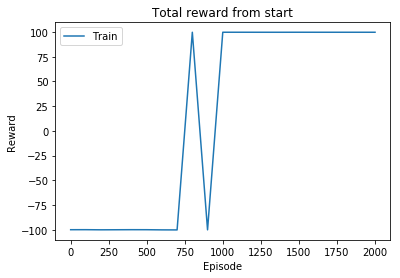

In [257]:
plt.plot(total_ep, total_rewards)
plt.title('Total reward from start')
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

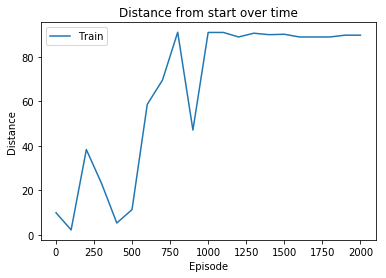

In [258]:
plt.plot(total_ep, total_distance)
plt.title('Distance from start over time')
plt.ylabel('Distance')
plt.xlabel('Episode')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
lib = cdll.LoadLibrary('libb.so')

class Env(object):
    def __init__(self):
        self.obj = lib.TestNet()
    
    def reset(self, init_x, init_y):
        lib.ResetTest.argtypes = [c_float, c_float]
        lib.ResetTest(self.obj, init_x, init_y)

    def step(self, new_x, new_y):
        lib.StepTest.argtypes = [c_float, c_float]
        lib.StepTest(self.obj, new_x, new_y)

In [17]:
def predict_distance() :
    
    env = Env()

    model = load_model(model_path)
    
    state, p_x, p_y = reset()
    env.reset(c_float(p_x), c_float(p_y))
    
    pl_x = p_x
    pl_y = p_y
    
    total_reward = 0
    
    while True:
    
        action = np.argmax(model.predict(state)[0])
        next_state, reward, done, p_x, p_y = step(action, pl_x, pl_y)
                
        env.step(c_float(p_x), c_float(p_y))
        
        state = next_state
        
        pl_x = p_x
        pl_y = p_y
        
        total_reward += reward
        
        if done:
            print("completed with reward: {}".format(total_reward))
            break;
            
predict_distance()

completed with reward: 99.7
